# 06 — Results & Visualization
UMAPs, QC overlays, cluster annotation, and optional enrichment.

**Input**: `data/processed/ssc_skin_scvi.h5ad`
**Output**: figures in `results/figures/`, tables in `results/tables/`

## 1) UMAP & QC sanity checks

In [1]:
import os
from pathlib import Path
import scanpy as sc
import pandas as pd

# --- 1) normalize working directory to the repo root (folder that contains "data/")
here = Path.cwd()
repo = None
for parent in [here] + list(here.parents):
    if (parent / "data").exists():
        repo = parent
        break
if repo is None:
    raise RuntimeError("Could not find a folder containing 'data/'. Start Jupyter from your repo or place this notebook inside it.")
os.chdir(repo)
print("Working directory set to:", Path.cwd())

# --- 2) show what the notebook can see
print("\nContents of data/processed/:")
proc_dir = Path("data/processed")
proc_dir.mkdir(parents=True, exist_ok=True)
for p in sorted(proc_dir.glob("*")):
    print(" -", p)

# --- 3) find the processed file robustly
default = proc_dir / "ssc_skin_scvi.h5ad"
candidates = []
if default.exists():
    candidates = [default]
else:
    candidates = list(Path.cwd().rglob("ssc_skin_scvi*.h5ad"))

if not candidates:
    raise FileNotFoundError(
        "Couldn't find 'ssc_skin_scvi.h5ad'. "
        "If you see a differently named file (e.g., ssc_skin_scvi_v1.h5ad), "
        "rename it or update the path below."
    )

# pick the most recent candidate
adata_path = max(candidates, key=lambda p: p.stat().st_mtime)
print("\nUsing:", adata_path.resolve())

# --- 4) load
sc.settings.verbosity = 3
sc.settings.figdir = "results/figures"
adata = sc.read_h5ad(adata_path)
adata


/home/glen/miniforge3/envs/ssc-scvi/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


Working directory set to: /home/glen/scleroderma-scvi

Contents of data/processed/:
 - data/processed/ssc_skin_qc.h5ad
 - data/processed/ssc_skin_scvi.h5ad

Using: /home/glen/scleroderma-scvi/data/processed/ssc_skin_scvi.h5ad


AnnData object with n_obs × n_vars = 68249 × 4000
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'connectivities', 'distances'

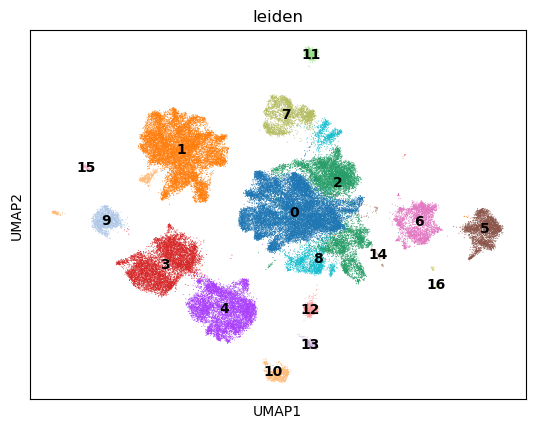

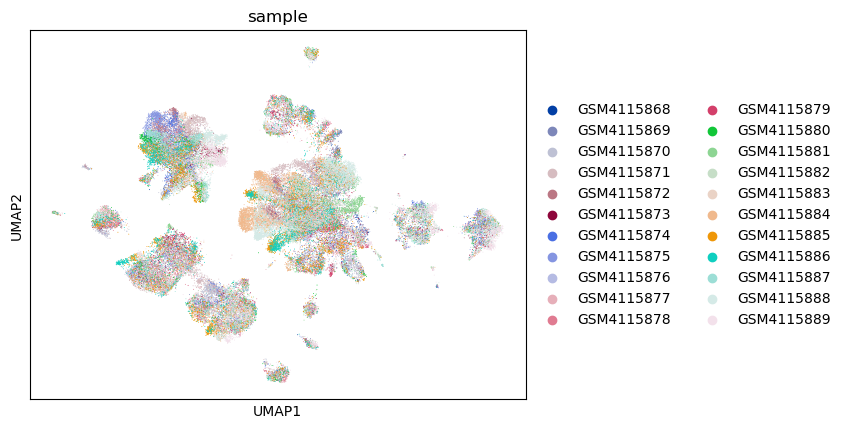

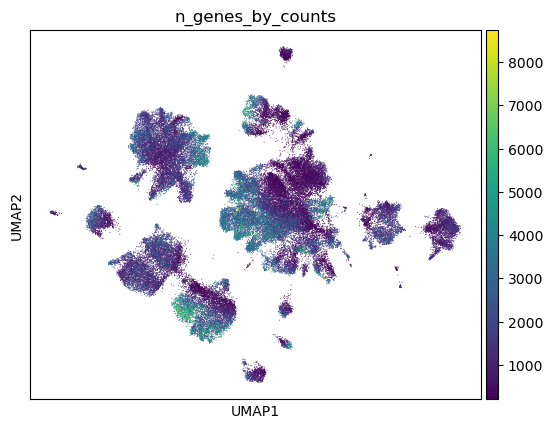

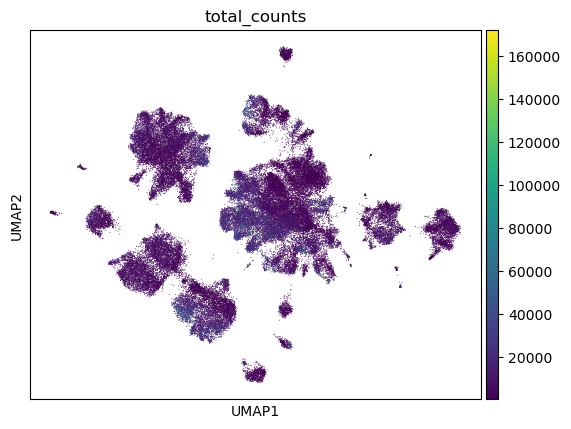

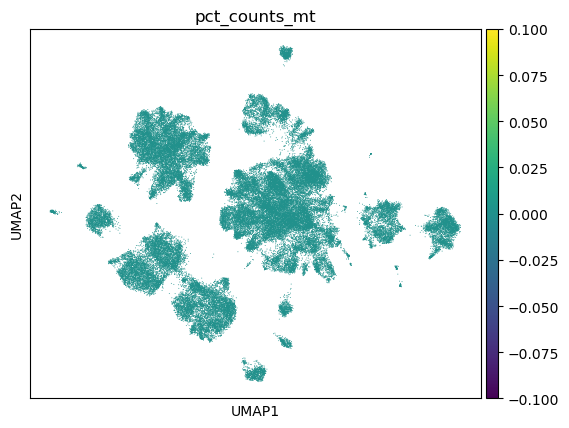

In [2]:
# Leiden clusters
sc.pl.umap(adata, color=['leiden'], legend_loc='on data', save='_leiden.png')

# Sample overlay (if present)
if 'sample' in adata.obs:
    sc.pl.umap(adata, color=['sample'], save='_sample.png')

# QC overlays (plot if available)
for k in ['n_genes_by_counts','total_counts','pct_counts_mt']:
    if k in adata.obs:
        sc.pl.umap(adata, color=[k], save=f'_{k}.png')

## 2) Marker inspection & quick DE (optional repeat)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


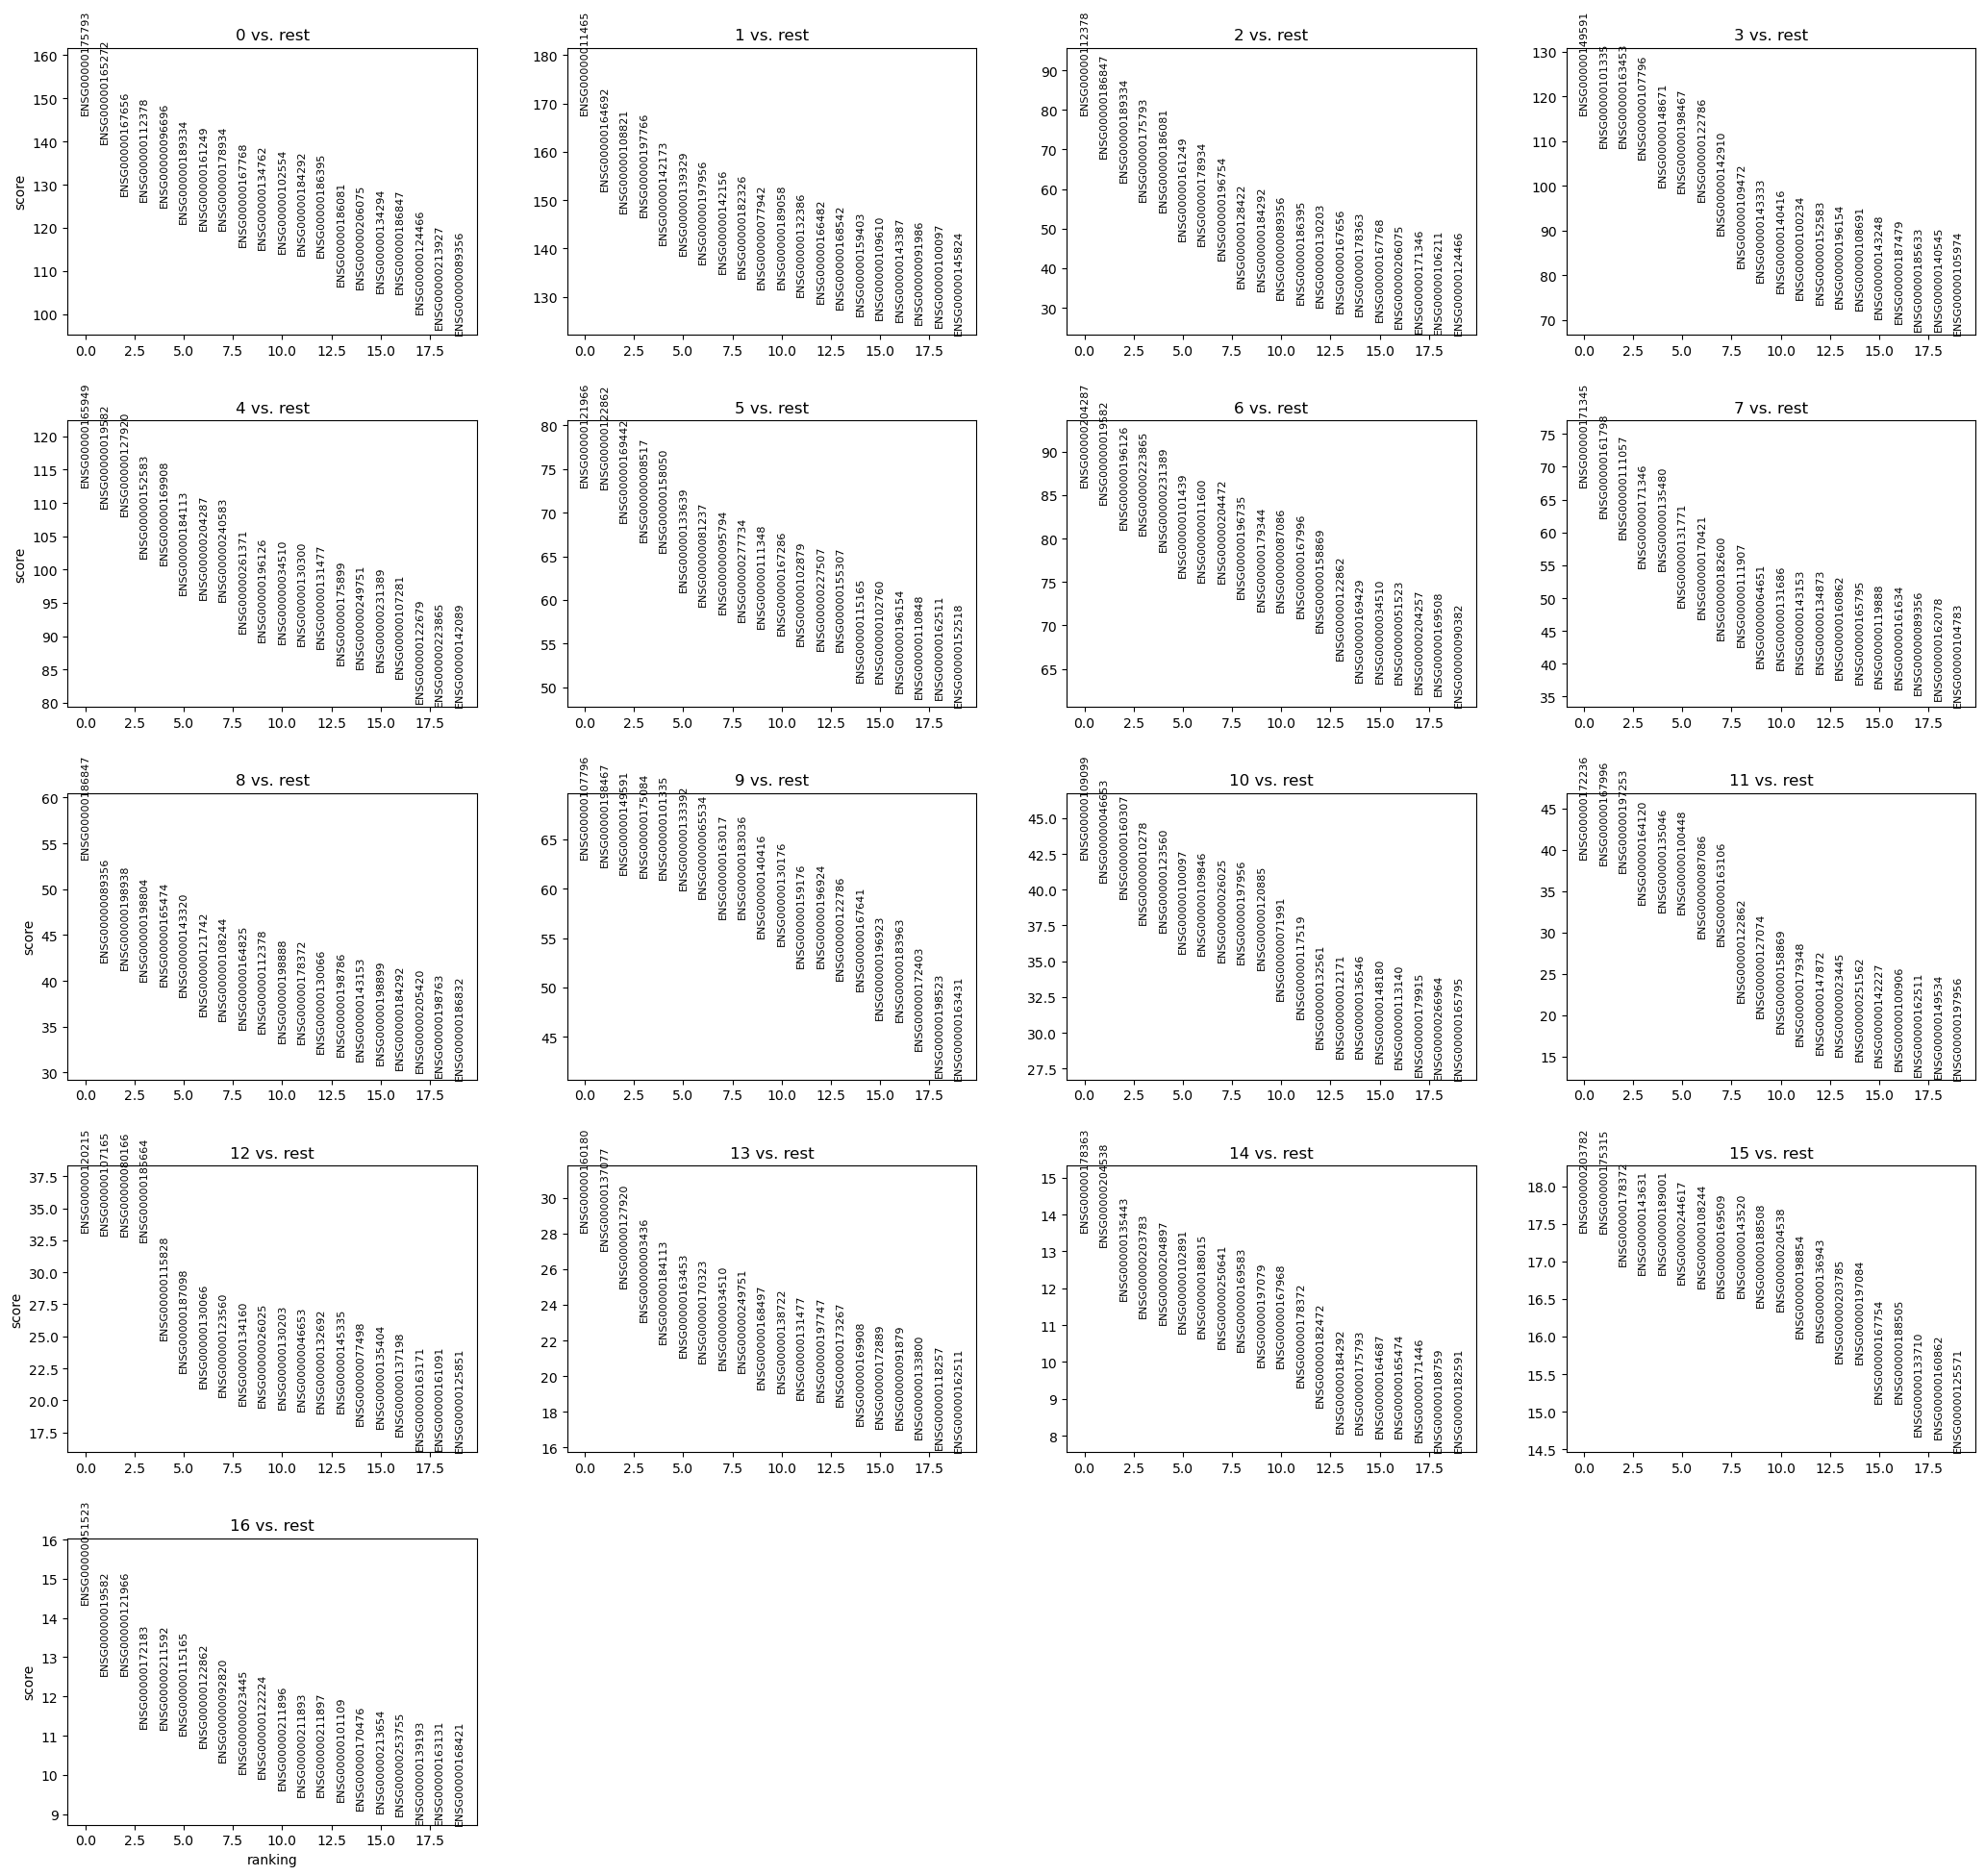

PosixPath('results/tables/de_leiden_wilcoxon_from_06.csv')

In [3]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, save='_top20.png')

de_df = sc.get.rank_genes_groups_df(adata, group=None)
out_csv = Path('results/tables/de_leiden_wilcoxon_from_06.csv')
de_df.to_csv(out_csv, index=False)
out_csv

## 3) Cell-type annotation scaffold

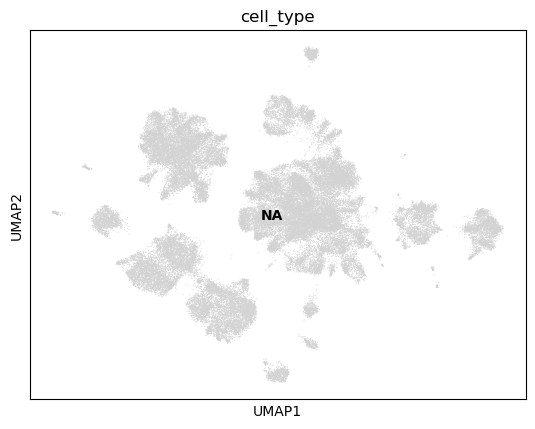

[saved] data/processed/ssc_skin_scvi_annot.h5ad


In [4]:
map_labels = {
    # '0': 'Fibroblasts',
    # '1': 'Keratinocytes',
    # '2': 'Endothelial',
    # '3': 'T cells',
    # '4': 'B cells',
}
adata.obs['cell_type'] = adata.obs['leiden'].map(map_labels).astype('category')
sc.pl.umap(adata, color=['cell_type'], legend_loc='on data', save='_celltype.png')
adata.write('data/processed/ssc_skin_scvi_annot.h5ad')
print('[saved] data/processed/ssc_skin_scvi_annot.h5ad')

## 4) Canonical marker panels (edit to taste)

In [5]:
panels = {
    'fibroblast': ['COL1A1','COL1A2','DCN','LUM','COL3A1'],
    'keratinocyte': ['KRT14','KRT5','KRT1','KRT10'],
    'endothelial': ['PECAM1','VWF','KDR','CLDN5'],
    't_cell': ['CD3D','CD3E','TRAC','IL7R','CCR7','GZMB'],
    'b_cell': ['MS4A1','CD79A','CD74','MZB1'],
    'myeloid': ['LYZ','S100A8','S100A9','FCGR3A','LRRK2'],
}
for name, genes in panels.items():
    try:
        sc.pl.umap(adata, color=genes, vmin=0, vmax='p99', cmap='viridis', save=f'_{name}_panel.png')
    except Exception as e:
        print(f'[warn] panel {name} failed: {e}')

[warn] panel fibroblast failed: 'Could not find key COL1A1 in .var_names or .obs.columns.'
[warn] panel keratinocyte failed: 'Could not find key KRT14 in .var_names or .obs.columns.'
[warn] panel endothelial failed: 'Could not find key PECAM1 in .var_names or .obs.columns.'
[warn] panel t_cell failed: 'Could not find key CD3D in .var_names or .obs.columns.'
[warn] panel b_cell failed: 'Could not find key MS4A1 in .var_names or .obs.columns.'
[warn] panel myeloid failed: 'Could not find key LYZ in .var_names or .obs.columns.'


<Figure size 2911.2x960 with 0 Axes>

<Figure size 2911.2x480 with 0 Axes>

<Figure size 2911.2x480 with 0 Axes>

<Figure size 2911.2x960 with 0 Axes>

<Figure size 2911.2x480 with 0 Axes>

<Figure size 2911.2x960 with 0 Axes>

## 5) Enrichment example (g:Profiler)

In [6]:
import pandas as pd
from gprofiler import GProfiler
from pathlib import Path
de_path = Path('results/tables/de_leiden_wilcoxon.csv')
df = pd.read_csv(de_path) if de_path.exists() else de_df.copy()
cluster = df['group'].unique()[0]
up = df.query('group == @cluster').sort_values('logfoldchanges', ascending=False).head(100)['names'].tolist()
gp = GProfiler(return_dataframe=True)
enr = gp.profile(organism='hsapiens', sources=['GO:BP','KEGG','REAC'], query=up)
out_enr = Path('results/tables')/f'enrichment_cluster{cluster}.csv'
enr.to_csv(out_enr, index=False)
print('[saved]', out_enr)
enr.head()

[saved] results/tables/enrichment_cluster0.csv


,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0009913,epidermal cell differentiation,5.695127e-14,True,"""The process in which a relatively unspecializ...",253,52,15,21026,0.288462,0.059289,query_1,"[GO:0008544, GO:0030855]"
1,REAC,REAC:R-HSA-6809371,Formation of the cornified envelope,4.197526e-13,True,Formation of the cornified envelope,129,43,13,11004,0.302326,0.100775,query_1,[REAC:R-HSA-6805567]
2,GO:BP,GO:0008544,epidermis development,2.001481e-12,True,"""The process whose specific outcome is the pro...",398,52,16,21026,0.307692,0.040201,query_1,[GO:0009888]
3,REAC,REAC:R-HSA-6805567,Keratinization,1.421262e-11,True,Keratinization,216,43,14,11004,0.325581,0.064815,query_1,[REAC:R-HSA-1266738]
4,GO:BP,GO:0030216,keratinocyte differentiation,2.558887e-11,True,"""The process in which a relatively unspecializ...",178,52,12,21026,0.230769,0.067416,query_1,"[GO:0009913, GO:0043588]"


## 6) Cluster size report

In [7]:
sizes = adata.obs['leiden'].value_counts().sort_index().rename('n_cells').to_frame()
sizes_path = Path('results/tables/cluster_sizes.csv')
sizes.to_csv(sizes_path)
print('[saved]', sizes_path)
sizes

[saved] results/tables/cluster_sizes.csv


,n_cells
leiden,
0,17446
1,12902
2,8383
3,7105
4,6904
5,2976
6,2921
7,2653
8,2454



# 7) Annotate clusters → save annotated object
  

In [8]:
map_labels = {
    # fill these based on your DE/UMAP
    # '0': 'Fibroblasts', '1': 'Keratinocytes', ...
}
adata.obs['cell_type'] = adata.obs['leiden'].map(map_labels).astype('category')
adata.write("data/processed/ssc_skin_scvi_annot.h5ad")


# 8) Export key figures

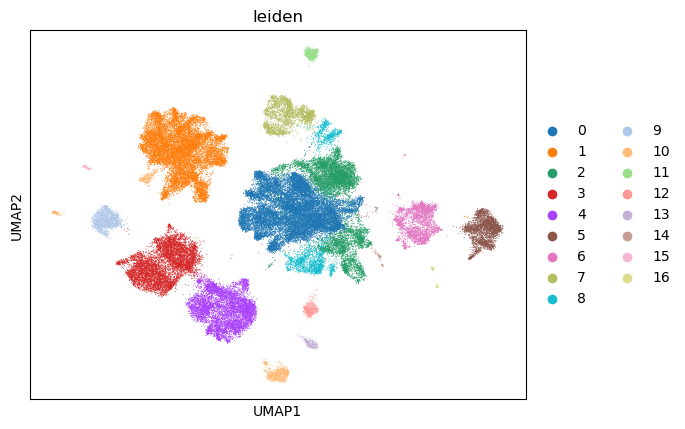

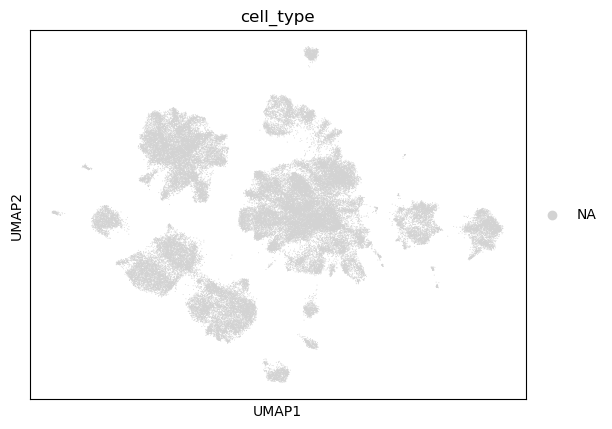

In [9]:
sc.pl.umap(adata, color=["leiden"], save="_leiden.png")
sc.pl.umap(adata, color=["cell_type"], save="_celltype.png")


# 9) Build Mapping Dictionary

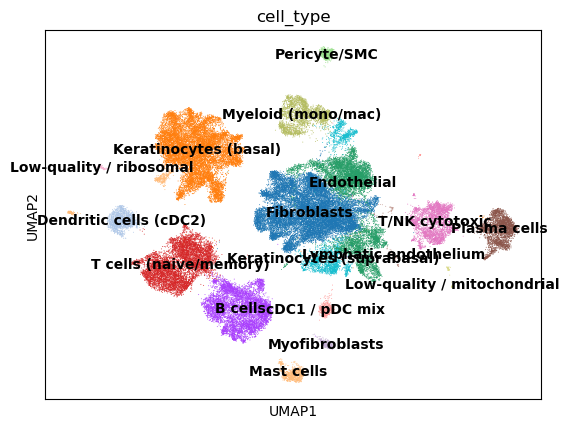

[saved] data/processed/ssc_skin_scvi_annot.h5ad


In [11]:
# Provisional labels for Leiden clusters 0..16
# (edit after checking top DE genes & marker panels)
map_labels = {
    "0":  "Fibroblasts",                 # COL1A1/COL1A2/DCN/LUM
    "1":  "Keratinocytes (basal)",       # KRT14/KRT5/KRT6(A/B)
    "2":  "Endothelial",                 # PECAM1/VWF/CLDN5/KDR
    "3":  "T cells (naive/memory)",      # CD3D/E, TRAC, IL7R, CCR7
    "4":  "B cells",                     # MS4A1, CD79A/B, CD74
    "5":  "Plasma cells",                # MZB1, XBP1, PRDM1, IGHG1
    "6":  "T/NK cytotoxic",              # NKG7, GNLY, PRF1, GZMB
    "7":  "Myeloid (mono/mac)",          # LYZ, S100A8/A9, FCGR3A
    "8":  "Keratinocytes (suprabasal)",  # KRT1/KRT10/IVL/SPRR1B
    "9":  "Dendritic cells (cDC2)",      # CD1C, FCER1A, IRF4
    "10": "Mast cells",                  # TPSAB1, CPA3, KIT
    "11": "Pericyte/SMC",                # RGS5, PDGFRB, MCAM, ACTA2
    "12": "cDC1 / pDC mix",              # CLEC9A/XCR1 (cDC1) or GZMB/LILRA4 (pDC)
    "13": "Myofibroblasts",              # ACTA2/TAGLN/MYL9 + collagen
    "14": "Lymphatic endothelium",       # PDPN/PROX1/LYVE1
    "15": "Low-quality / ribosomal",     # RPS*/RPL* dominant
    "16": "Low-quality / mitochondrial", # MT-CO1/MT-ND*/MT-CYB dominant
}
adata.obs["cell_type"] = adata.obs["leiden"].map(map_labels).astype("category")
sc.pl.umap(adata, color=["cell_type"], legend_loc="on data", save="_celltype_provisional.png")
adata.write("data/processed/ssc_skin_scvi_annot.h5ad")
print("[saved] data/processed/ssc_skin_scvi_annot.h5ad")


# 10) Quality Checks to Validate/Adjust

In [12]:
# Inspect top DE for each cluster (already plotted) + overlay key markers:
panels = {
    "Fibroblast_core": ["COL1A1","COL1A2","COL3A1","DCN","LUM"],
    "Myofibroblast":   ["ACTA2","TAGLN","MYL9","CNN1"],
    "Kerat_basal":     ["KRT14","KRT5","KRT6A","KRT6B"],
    "Kerat_suprabasal":["KRT1","KRT10","IVL","SPRR1B"],
    "Endothelial":     ["PECAM1","VWF","KDR","CLDN5","CDH5"],
    "Lymph_endothelium":["PROX1","PDPN","LYVE1"],
    "T_naive_mem":     ["CD3D","CD3E","TRAC","IL7R","CCR7"],
    "T_cytotoxic":     ["NKG7","GNLY","PRF1","GZMB"],
    "B_cell":          ["MS4A1","CD79A","CD79B","CD74"],
    "Plasma_cell":     ["MZB1","XBP1","PRDM1","IGHG1"],
    "Myeloid":         ["LYZ","S100A8","S100A9","FCGR3A"],
    "Mast":            ["TPSAB1","CPA3","KIT"],
    "cDC2":            ["CD1C","FCER1A","IRF4"],
    "cDC1":            ["CLEC9A","XCR1","BATF3"],
    "pDC":             ["GZMB","LILRA4","IRF7","JCHAIN"],
    "Pericyte_SMC":    ["RGS5","PDGFRB","MCAM","MYH11","ACTA2"],
}
for name, genes in panels.items():
    genes = [g for g in genes if g in adata.var_names]
    if genes:
        sc.pl.umap(adata, color=genes, vmin=0, vmax="p99", cmap="viridis", save=f"_{name}.png")


# 11) Handy helpers (spot QC clusters quickly)

In [13]:
import numpy as np
mt_frac = adata.obs.get("pct_counts_mt", None)
if mt_frac is not None:
    print("Clusters with high mito (% mt > 12%):")
    print(adata.obs.groupby("leiden")["pct_counts_mt"].median().sort_values(ascending=False).head(5))

# ribosomal signal (rough)
ribo_genes = [g for g in adata.var_names if g.startswith(("RPS","RPL"))]
adata.obs["ribo_score"] = adata[:, ribo_genes].X.mean(axis=1).A1 if hasattr(adata[:, ribo_genes].X, "A1") else adata[:, ribo_genes].X.mean(axis=1)
print("Top clusters by ribosomal score:")
print(adata.obs.groupby("leiden")["ribo_score"].median().sort_values(ascending=False).head(5))


Clusters with high mito (% mt > 12%):
leiden
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: pct_counts_mt, dtype: float32


/tmp/ipykernel_36953/1859941511.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata.obs.groupby("leiden")["pct_counts_mt"].median().sort_values(ascending=False).head(5))


ZeroDivisionError: float division by zero

There are two things are going on:

All mito medians show 0 → likely because the mitochondrial flag wasn’t (re)computed on this object (or var names are Ensembl IDs so "MT-" wasn’t detected).

ZeroDivisionError for ribosomal score → your current adata has no ribosomal genes left (HVG filtering removed most/all RPS*/RPL*), so taking a mean over 0 columns blows up.


In [14]:
# 11B) Recompute mito/ribo metrics on the current object (works if symbols available)

In [15]:
import scanpy as sc
import pandas as pd

# Use gene symbols if present; else fall back to var_names
gene_sym = adata.var["gene_symbol"] if "gene_symbol" in adata.var.columns else adata.var_names.to_series()

# Mito & ribo flags
adata.var["is_mito"] = gene_sym.str.upper().str.startswith(("MT-","MT."))
adata.var["is_ribo"] = gene_sym.str.upper().str.startswith(("RPS","RPL"))

# Recompute QC metrics (adds pct_counts_is_mito / pct_counts_is_ribo to .obs)
sc.pp.calculate_qc_metrics(adata, qc_vars=["is_mito","is_ribo"], percent_top=None, inplace=True)

# Rename to nice column names if you like
adata.obs.rename(columns={
    "pct_counts_is_mito":"pct_counts_mt",
    "pct_counts_is_ribo":"pct_counts_ribo"
}, inplace=True)

# Quick summaries
print(adata.obs[["pct_counts_mt","pct_counts_ribo"]].describe())
print(adata.obs.groupby("leiden")[["pct_counts_mt","pct_counts_ribo"]].median())


       pct_counts_mt  pct_counts_mt  pct_counts_ribo
count        68249.0   68249.000000     68249.000000
mean             0.0       8.732690         2.010591
std              0.0       5.896961         1.546167
min              0.0       0.000000         0.000000
25%              0.0       5.017923         1.075467
50%              0.0       7.350689         1.856359
75%              0.0      10.654437         2.659920
max              0.0      55.203217        26.758707
        pct_counts_mt  pct_counts_mt  pct_counts_ribo
leiden                                               
0                 0.0       9.606883         2.322574
1                 0.0       5.605365         1.337885
2                 0.0       6.840808         2.971125
3                 0.0       6.023280         1.499440
4                 0.0       5.818461         1.685275
5                 0.0       6.208659         2.424637
6                 0.0       5.254200         1.623423
7                 0.0      10.885952 

/tmp/ipykernel_36953/2440248100.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata.obs.groupby("leiden")[["pct_counts_mt","pct_counts_ribo"]].median())


In [21]:
import pandas as pd

# Drop duplicate columns by name, keep the first occurrence
adata.obs = adata.obs.loc[:, ~adata.obs.columns.duplicated()]
print("After cleanup:", adata.obs.columns.tolist())


After cleanup: ['sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type', 'total_counts_is_mito', 'log1p_total_counts_is_mito', 'total_counts_is_ribo', 'log1p_total_counts_is_ribo', 'pct_counts_ribo']


In [22]:
# mito %
mito_df = adata.obs.groupby("leiden", observed=True)[["pct_counts_mt"]].median()
mito_df = mito_df.reset_index()  # make leiden a column instead of index
mito_sorted = mito_df.sort_values("pct_counts_mt", ascending=False)
print("Top clusters by mito%:")
print(mito_sorted.head())

# ribo %
ribo_df = adata.obs.groupby("leiden", observed=True)[["pct_counts_ribo"]].median()
ribo_df = ribo_df.reset_index()
ribo_sorted = ribo_df.sort_values("pct_counts_ribo", ascending=False)
print("\nTop clusters by ribo%:")
print(ribo_sorted.head())


Top clusters by mito%:
  leiden  pct_counts_mt
0      0            0.0
1      1            0.0
2      2            0.0
3      3            0.0
4      4            0.0

Top clusters by ribo%:
   leiden  pct_counts_ribo
14     14         3.125485
2       2         2.971125
11     11         2.702672
5       5         2.424637
0       0         2.322574
